In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
FLUX_TO_MM_YR = FLUX_TO_MM_HR*24*365
HOURS_TO_RADIANS = 2*np.pi/24


In [2]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'


##### open cmip5
# input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_regridded/grid1/'

#### open cmip6
# input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results//GPM_bin_pt2_hr_15_yr_regridded/grid1/GPM_bin_pt2_hr_15_yr/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'


# paths to mean climate fields 



input_data_dir_rlut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/'
input_data_dir_rsut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/' 
input_data_dir_pr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/'
input_data_dir_clt = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/' 

mean_fields_to_rel_path_map = {
    'rlut': input_data_dir_rlut,
    'rsut': input_data_dir_rsut,
    'pr': input_data_dir_pr,
    'clt':input_data_dir_clt
}



In [3]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [11]:
# len(unique_cmip5_models)

In [4]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




In [29]:
# unique_cmip6_models

## Take mean accross seasons for GPM (circular for phase!)

In [5]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

### compute means
# # # take mean across seasons using circular mean for phase
# ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
# #                                    kwargs = {'low' : 0.0, 'high' : 24.0},
#                                    input_core_dims=[["season"]], 
#                                    vectorize = True)
# # compute yearly mean other data 
# ds_gpm = ds_gpm.mean(dim = 'season')
# ds_gpm['phase_season'] = ds_gpm_phase_year_mean

#########

ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [9]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = False,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 50.3 s, sys: 13.3 s, total: 1min 3s
Wall time: 1min 3s


In [70]:
# df[df['model_name'] == 'GFDL-CM4'].plot(y = 'phase_season', kind = 'hist', bins = 30)
# sns.distplot(df[df['model_name'] == 'GFDL-ESM4']['phase_season'].values, bins = 150)
# plt.xlabel('Phase [hours]')
# plt.grid()


In [104]:
# hist_ax_gpm
# sns.distplot(ax)
# ax_hist

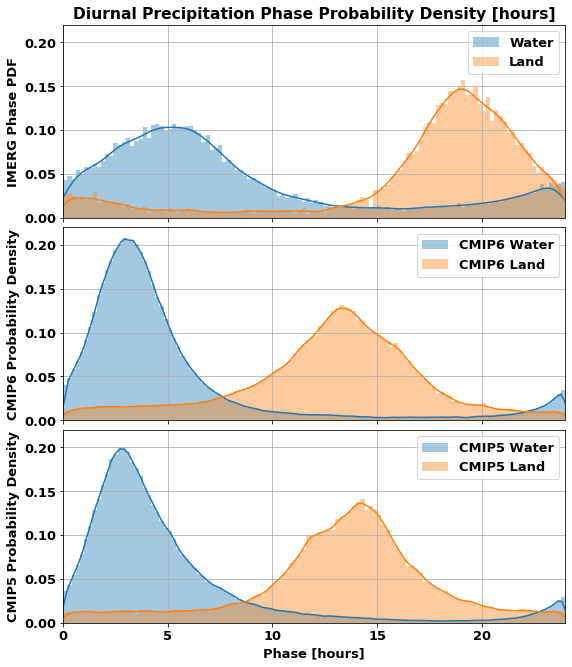

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [132]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,11))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6 Probability Density')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5 Probability Density',
                   xlabel = 'Phase [Hour]')

fig.subplots_adjust(hspace=.05)



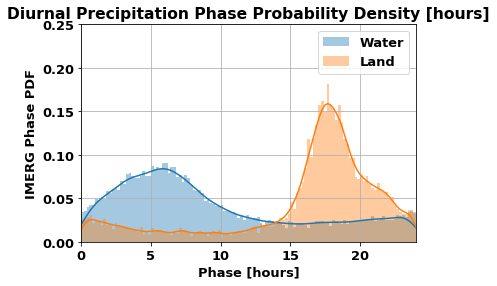

In [261]:
land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

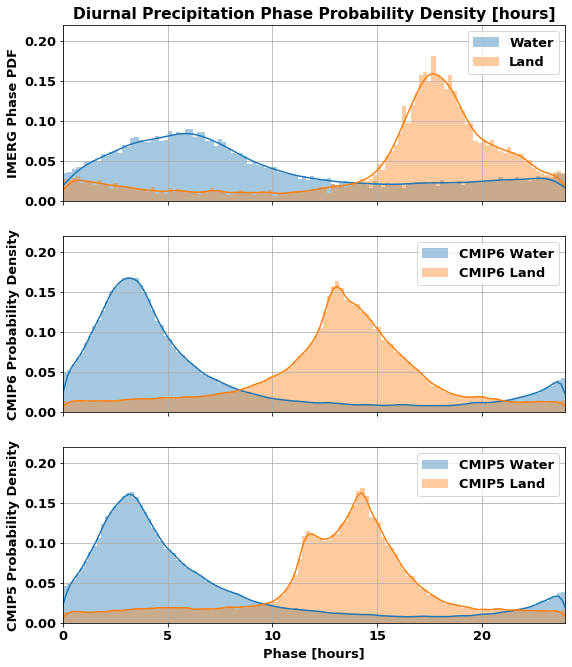

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [262]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)



fig, ax_hist_season = plt.subplots(3, 1, sharex = True, figsize = (9,11))

season_ii = 'JJA'

land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   ax = ax_hist_season[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist_season[1],
                   ylabel = 'CMIP6 Probability Density')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist_season[2],
                   ylabel = 'CMIP5 Probability Density',
                   xlabel = 'Phase [Hour]')

# fig.subplots_adjust(hspace=.05)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [8]:
df_cmip6 = df[(df['cmip_identifier'] == 'CMIP6')]
df_cmip6 = df_cmip6[df_cmip6['model_name'] != 'IPSL-CM6A-LR'] # Remove
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']
field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



NameError: name 'df' is not defined

In [385]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
df_lat_lon_mode_ampl = df_for_stats.round(6).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)
cmips_mode_df = pd.DataFrame()
cmips_mode_df['phase_mode'] = df_lat_lon_mode_phase
cmips_mode_df['ampl_mode'] = df_lat_lon_mode_ampl
cmips_mode_ds = xr.Dataset.from_dataframe(cmips_mode_df)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

KeyboardInterrupt: 

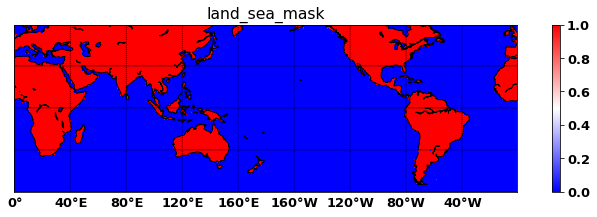

In [19]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))



In [23]:
# ds_gpm.isel(season = 0)


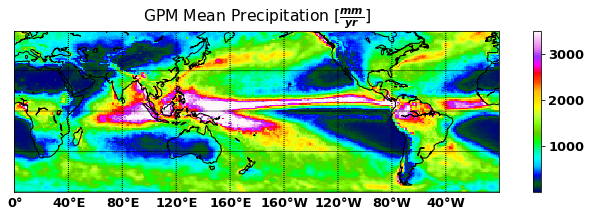

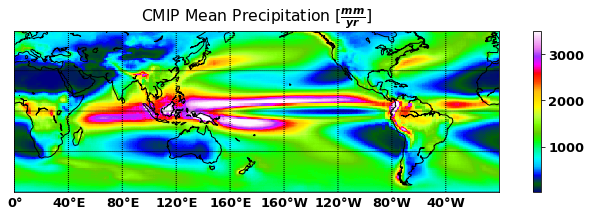

In [166]:
make_single_plot(ds_gpm['mu_season']*24*365, 
                 title = r'GPM Mean Precipitation [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *24*365, 
                 title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

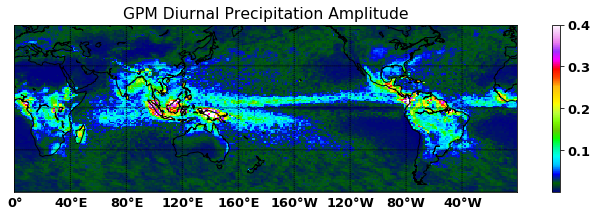

In [162]:
make_single_plot(ds_gpm['ampl_season'], 
                 title = r'GPM Diurnal Precipitation Amplitude',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

In [ ]:
# plot mean
make_single_plot(cmips_mean_ds['ampl_season'], 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

# plot mode
make_single_plot(cmips_mode_ds['ampl_mode'], 
                 title = r'CMIP6 Mode Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmin = 0, vmax = 0.05)


In [22]:
# cmips_mode_ds['ampl_mode']

In [ ]:
make_single_plot(cmips_mean_ds['ampl_season'].where(cmips_mean_ds['ampl_season']> 0.02), 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

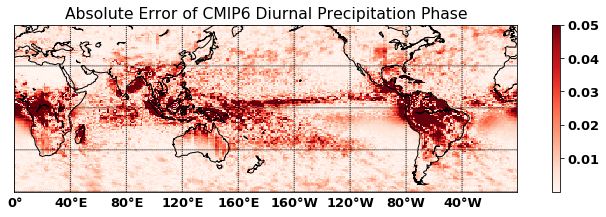

In [27]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

In [37]:
%run diurnal_utils.py

In [ ]:
# # plot mean
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)


# plot mode
make_single_plot(cmips_mode_ds['phase_mode'], 
                 title = r'Mode CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)


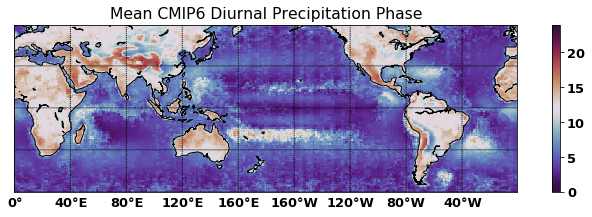

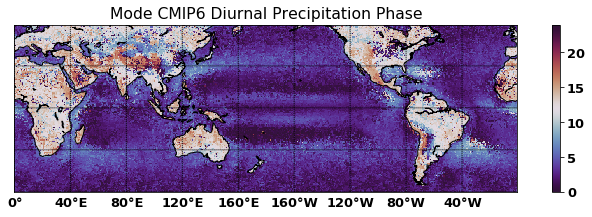

In [161]:
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)


# plot mode
make_single_plot(cmips_mode_ds['phase_mode'], 
                 title = r'Mode CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

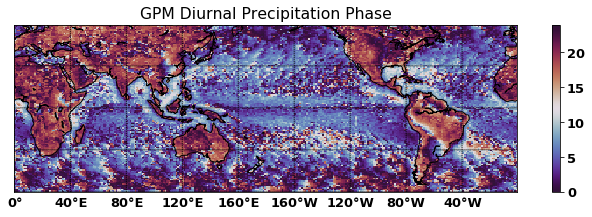

In [178]:
make_single_plot(ds_gpm['phase_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_mean_spatial.png', dpi = 300)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'))

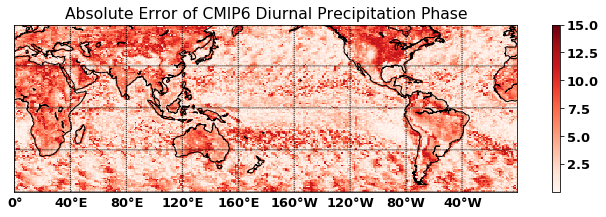

In [32]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [174]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [309]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
min_lat, max_lat = 0, 30
field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
# min_lat, max_lat = -30, 30

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': True})


# rr = _get_mean_field(field_name = 'rsut',
#                       data_dir = mean_fields_to_rel_path_map['rsut'],
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [304]:
# field_means_df

In [265]:
%run model_by_model_analysis_helper.py




In [48]:
# df_for_stats[df_for_stats['mu_season'] > 0.1]



In [386]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  additional_stats = True,)


# ### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
min_lat, max_lat = 0, 60
# # # min_lat, max_lat = 30, 60
# # # min_lat, max_lat = 0, 60

# # # min_lat, max_lat = 30, 60
absolute_values = False

# # print(min_lat, max_lat)
# df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# model_error_stats_df = compute_stats(df_for_stats_filt,
#                  df_for_stats_true_filt,
#                  agg_method = 'mean',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)
                

    
    

model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
                 df_for_stats_true_filt_water,
                 field = 'phase_season',
                 additional_stats = True, 
                 agg_method = 'mode',)

model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
                 df_for_stats_true_filt_land,
                 field = 'phase_season',
                 additional_stats = True, 
                 agg_method = 'mode',)

In [387]:
season_ii = 'JJA'

df_for_analysis = model_error_stats_df_water
df_for_analysis = df_for_analysis.reset_index('season')
df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)

In [212]:
# all_stats_df

## Make Correlation Heatmap

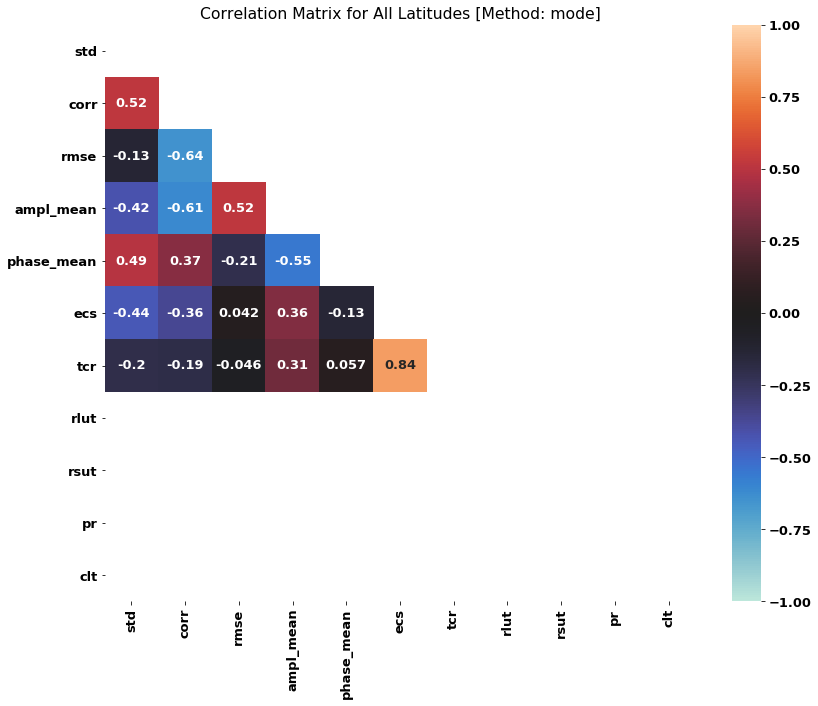

In [388]:

corr_mat_ds = all_stats_df

plot_corr_matrix(corr_mat_ds)

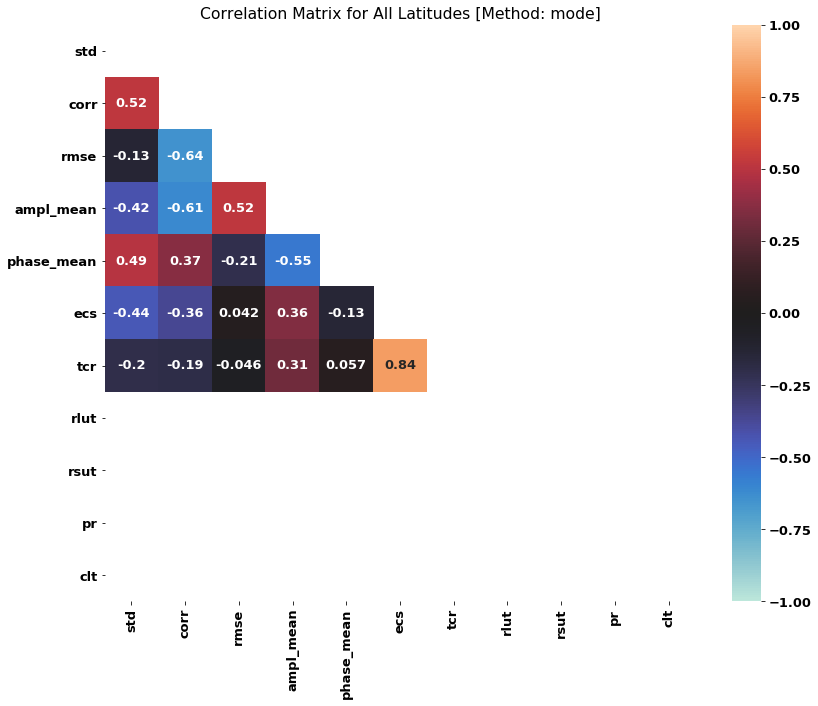

In [367]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [331]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',):
    plt.figure(figsize = (8,5))
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
    #         print(xx,yy)
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    plt.xlabel('Phase Mean [Hours]')
    plt.ylabel('ECS')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
#     plt.annotate('Correlation:' + '{:.3f}'.format(corr), xy=(1.05, -0.1), xycoords='axes fraction')
    plt.annotate('Corr:' + '{:.3f}'.format(corr), xy=(0.75, 0.01), xycoords='axes fraction')


    plt.tight_layout()

-0.13369407668373412


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

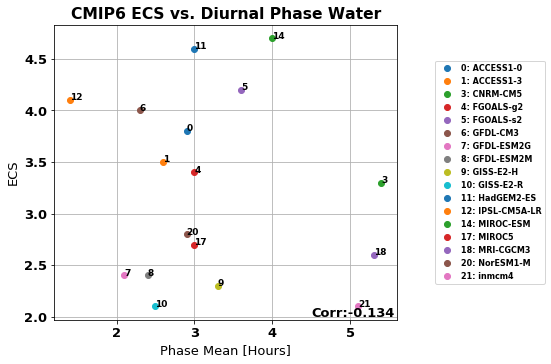

In [390]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



In [148]:
# all_stats_df

0.6331032009893186


(array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 9 Text xticklabel objects>)

<Figure size 504x720 with 0 Axes>

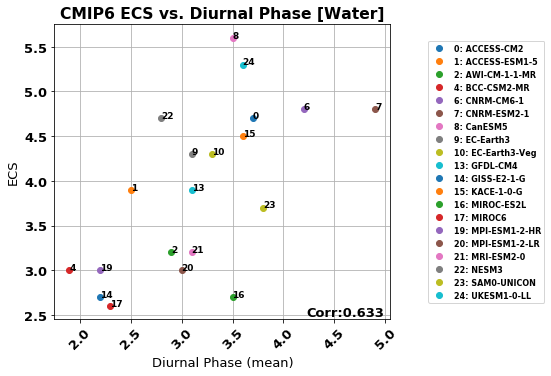

In [284]:
plt.figure(figsize = (7,10))
metric_scatter(all_stats_df,  x_field = 'phase_mean',  y_field = 'ecs')
plt.title('CMIP6 ECS vs. Diurnal Phase [Water]', weight = 'bold')

# plt.ylabel(r'SWR [$\frac{W}{m^2}$]')
# plt.ylabel
plt.xlabel('Diurnal Phase (mean)')
plt.xticks(rotation=45)
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_new.png', dpi = 300)




In [160]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

['BCC-CSM2-MR']

0.19058409942436752


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Amplitude')

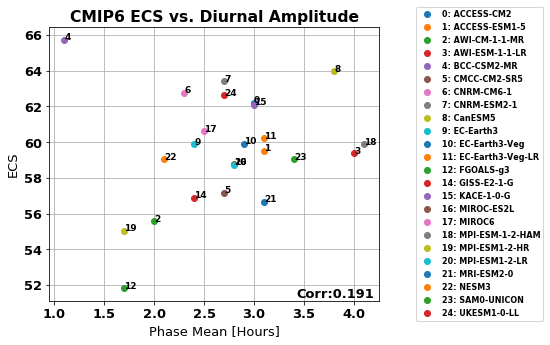

In [333]:
metric_scatter(all_stats_df,  
               y_field = 'clt', x_field = 'phase_mean')
plt.title('CMIP6 ECS vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [248]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.7618790994627989


Text(0.5, 1, 'CMIP6 ECS vs. TCR')

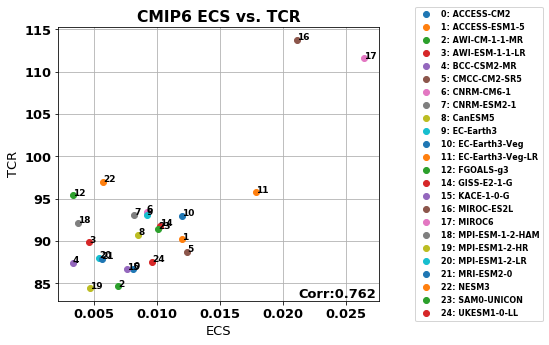

In [335]:
metric_scatter(all_stats_df, x_field = 'ampl_mean', y_field = 'rsut' )
plt.xlabel('ECS')
plt.ylabel('TCR')
plt.title('CMIP6 ECS vs. TCR', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

NameError: name 'model_error_stats_df' is not defined

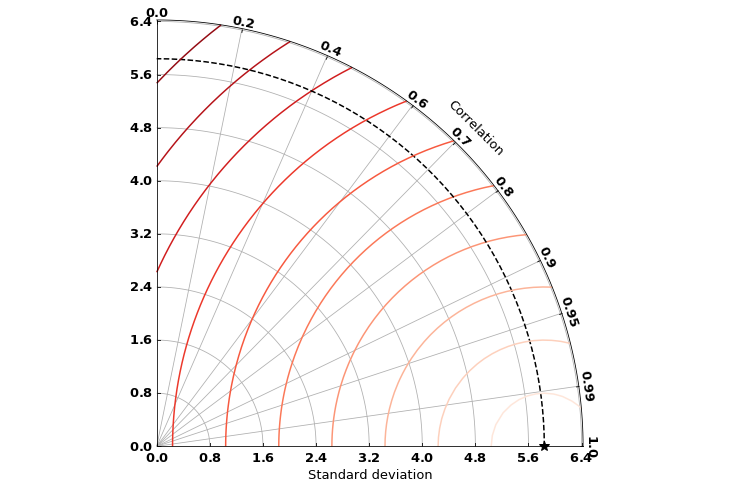

In [39]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. GPM Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

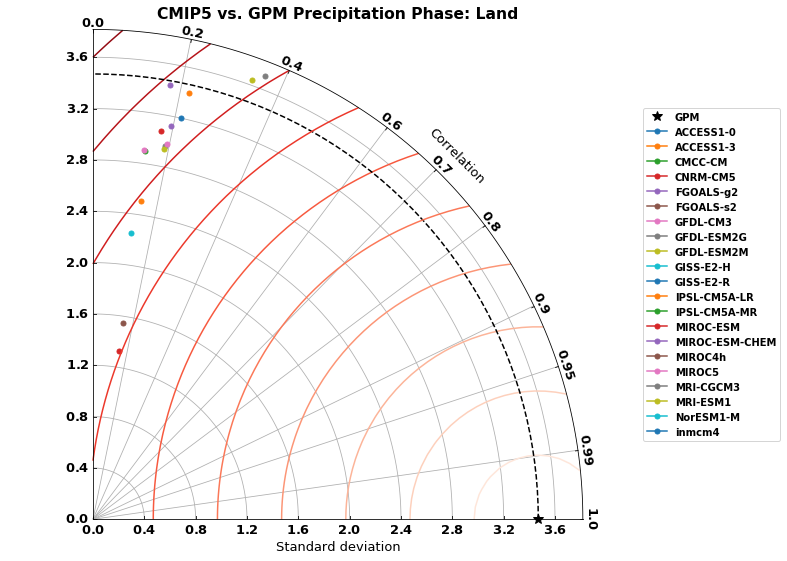

In [150]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

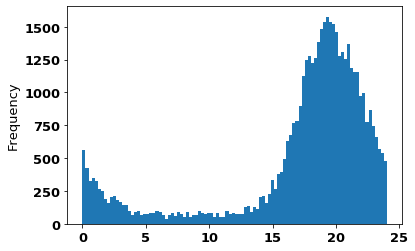

In [184]:
df_for_stats_true_land['phase_season'].plot.hist(bins = 100)

In [194]:
df

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.000029      0.000002     0.000002      2.409531   
      0.0     0.000024      0.000001     0.000002      5.032166   
      0.0     0.000025      0.000002     0.000002      3.635818   
      0.0     0.000025      0.000001     0.000002      2.712281   
      0.0     0.000024      0.000002     0.000002      1.638110   
...                ...           ...          ...           ...   
 59.5 359.5   0.000023      0.000002     0.000002     21.499995   
      359.5   0.000041      0.000003     0.000004      2.060632   
      359.5   0.000037      0.000003     0.000003      1.820820   
      359.5   0.000041      0.000003     0.000004      3.159079   
      359.5   0.000031      0.000002     0.000003      3.532080   

                model_name cmip_indentifier  land_sea_mask  
lat   lon                                                   
-60.0 0.0           MIROC5            CMIP5              0  
      0.0         MRI-ESM1            CMIP5              0  
      0.0        ACCESS1-3            CMIP5              0  
      0.0       HadGEM2-ES            CMIP5              0  
      0.0          CMCC-CM            CMIP5              0  
...                    ...              ...            ...  
 59.5 359.5    GISS-E2-1-G            CMIP6              0  
      359.5  AWI-CM-1-1-MR            CMIP6              0  
      359.5     ACCESS-CM2            CMIP6              0  
      359.5  ACCESS-ESM1-5            CMIP6              0  
      359.5     KACE-1-0-G            CMIP6              0  

[8640000 rows x 7 columns]

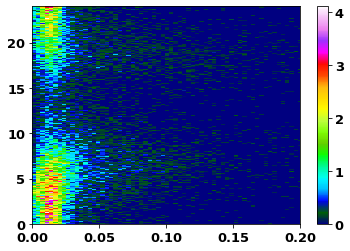

In [100]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
_ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
              density = True, cmap = plt.get_cmap('gist_ncar'))
plt.xlim([0, 0.2])
plt.colorbar()

NameError: name 'df_for_stats_true_water' is not defined

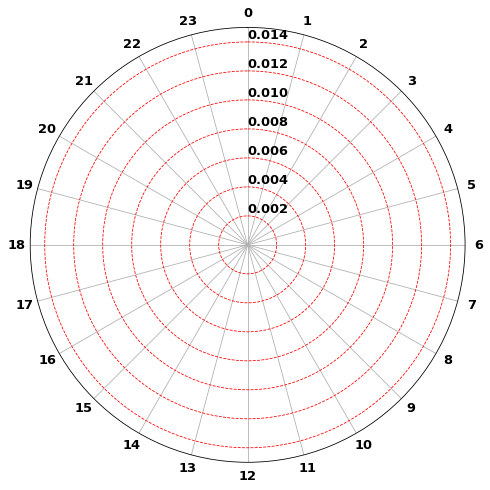

In [33]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = PhaseDiagram(gpm_water_std, 
                          fig = fig, 
                          label = 'GPM', 
                          y_lim=(0, 0.015),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_water['phase_season'].round(1)), 
                           ampl = mode_apply(df_for_stats_true_water['ampl_season'].round(4)), 
                           marker = '*', 
                           c = 'b',
                           label = 'GPM-Water', 
                           markersize = 15)

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_land['phase_season'].round(1)), 
                           ampl = mode_apply(df_for_stats_true_land['ampl_season'].round(4)), 
                           marker = '*', 
                           c = 'g',
                           label = 'GPM-Land', 
                           markersize = 15)

# plot model points 
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):
#     print(model_error_stats[model_name])
#     print(model_error_stats_df.loc[model_name,:]['phase_mean'])
    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = 7,
                         weight = 'bold')
    
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = 9,
                         weight = 'bold')


# plt.legend()
leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
# for n, text in enumerate(leg.markerscale):
#     print( n, text)
#     text.set_color( color_l[n] )

plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP6 vs. GPM Poleward of 35 N/S (Method: mode)', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'phase_ampl_plots/CMIP6/' + 'all_cmip6_land_water_pw_35NS.png', dpi = 300)

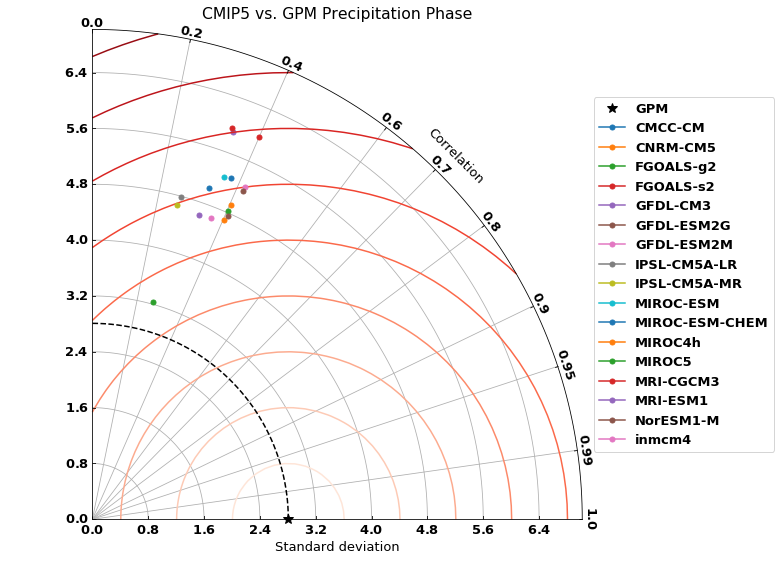

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)